In [1]:
%pip install fairlearn

You should consider upgrading via the '/Users/tarasbohdan/Desktop/university/Experiments-AAAI-24/virny_venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, count, plot_model_comparison, demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference
from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch
import seaborn as sns
import matplotlib.pyplot as plt

# Task Implementation

In [3]:
class Config:
  file_name = './data/student-mat.csv'

In [4]:
sensitive_variables = ["sex", "age"]

In [5]:
data = pd.read_csv(Config.file_name, delimiter=';')

In [6]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [7]:
X_df = data.drop(['G3'], axis=1)

In [8]:
y_df = (data['G3'] >= 10) * 1 # convert to binary | GridSearch
y_df.head()

0    0
1    0
2    1
3    1
4    1
Name: G3, dtype: int64

In [9]:
X_df['score_greater_10'] = y_df

In [10]:
count_df = X_df.groupby(['sex', 'score_greater_10']).size().unstack(fill_value=0)
count_df_age = X_df.groupby(['age', 'score_greater_10']).size().unstack(fill_value=0)

In [11]:
X_df.groupby('sex')['score_greater_10'].value_counts()

sex  score_greater_10
F    1                   133
     0                    75
M    1                   132
     0                    55
Name: score_greater_10, dtype: int64

In [12]:
grouped = X_df.groupby('sex')['score_greater_10'].value_counts().unstack().fillna(0)
DI_before = (grouped.loc['F', 1] / grouped.loc['F', :].sum()) / (grouped.loc['M', 1] / grouped.loc['M', :].sum())

print("Disparate Impact (DI) Before Fairness Measures:", DI_before)

Disparate Impact (DI) Before Fairness Measures: 0.9058493589743588


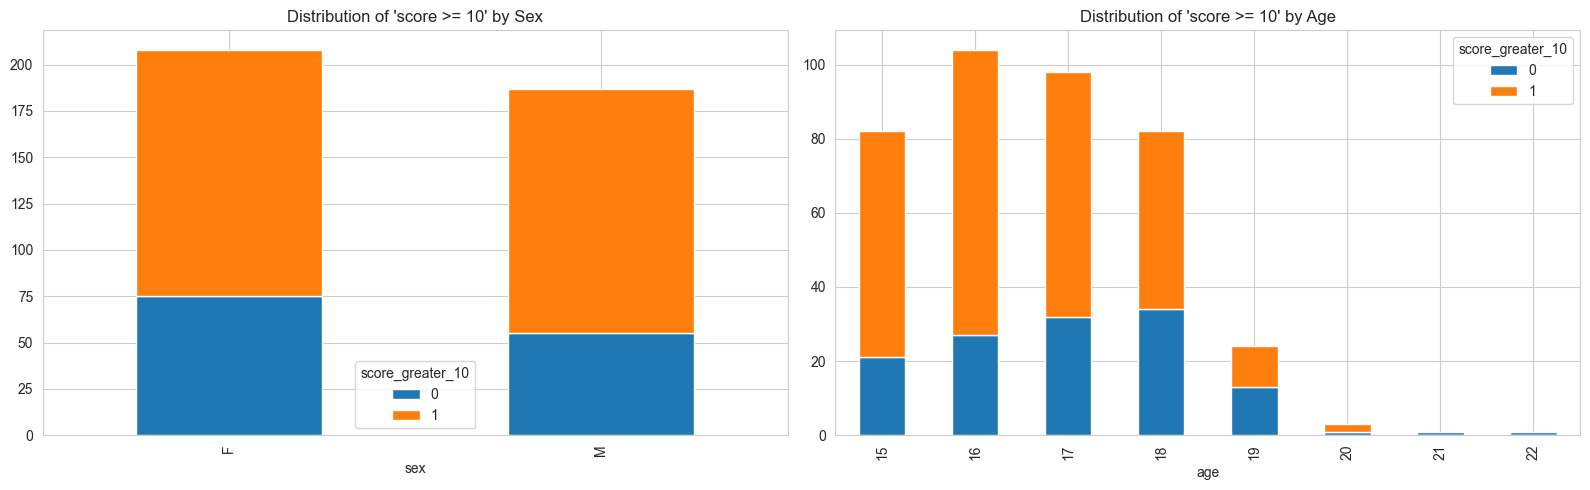

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
count_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title("Distribution of 'score >= 10' by Sex")

plt.subplot(1, 2, 2)
count_df_age.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title("Distribution of 'score >= 10' by Age")

plt.tight_layout()
plt.show()

In [14]:
X_df.drop(['score_greater_10'], axis=1, inplace=True)

In [15]:
A = X_df[sensitive_variables]
X = X_df.drop(labels=sensitive_variables, axis=1)
X = pd.get_dummies(X)

- Q: why to scale data?
- Q: research StandardScaler

In [16]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [17]:
le = LabelEncoder()
Y_encoded = le.fit_transform(y_df)

Adding stratify will guarantee the proportion of 1 is the same as in original data.

In [18]:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(
    X_scaled, Y_encoded, A, test_size=0.4, random_state=0, stratify=Y_encoded
)

In [19]:
X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

- Q: how DecisionTreeClassifier works in details?

In [20]:
performance_metric = accuracy_score
fairness_metric = selection_rate

# predictor = LogisticRegression(C=0.001, max_iter=100, penalty='l1', solver='liblinear')
predictor = DecisionTreeClassifier()
predictor.fit(X_train, Y_train)

DecisionTreeClassifier()

In [21]:
pr = predictor.predict(X_test)
print(accuracy_score(Y_test, pr))

0.8987341772151899


### GridSearchCV for LogisticRegression

In [22]:
param_grid = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30, 40],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2', None],
    'decisiontreeclassifier__class_weight': [None, 'balanced'],
    'decisiontreeclassifier__random_state': [42]
}


In [23]:
pipeline = Pipeline([
    ('decisiontreeclassifier', DecisionTreeClassifier())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [24]:
grid_search.fit(X_train, Y_train)

/Users/tarasbohdan/Desktop/university/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/tarasbohdan/Desktop/university/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/tarasbohdan/Desktop/university/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/tarasbohdan/Desktop/university/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packag

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__class_weight': [None,
                                                                  'balanced'],
                         'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [None, 10, 20, 30,
                                                               40],
                         'decisiontreeclassifier__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2',
                                                                  None],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
                         'decisiontreeclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'decisiontreeclassifier__random_state': [42],
                         'decisiontreeclassifier__splitter': ['best',
                                                              'random']})

In [25]:
print(grid_search.best_params_)

{'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__random_state': 42, 'decisiontreeclassifier__splitter': 'best'}


In [26]:
grid_search.best_score_

0.8859929078014185

In [27]:
from sklearn.metrics import accuracy_score, classification_report

Y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

report = classification_report(Y_test, Y_pred)
print("Classification Report:\n", report)

Accuracy: 0.879746835443038
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84        52
           1       0.98      0.84      0.90       106

    accuracy                           0.88       158
   macro avg       0.86      0.90      0.87       158
weighted avg       0.90      0.88      0.88       158



### MetricFrame

- Q: what is count metric?
- Q: what is selection rate? how it was calculated?

accuracy            0.879747
selection_rate      0.575949
count             158.000000
dtype: float64
         accuracy  selection_rate  count
sex age                                 
F   15   0.692308        0.461538   13.0
    16   0.777778        0.500000   18.0
    17   0.916667        0.500000   24.0
    18   1.000000        0.625000   16.0
    19   0.833333        0.666667    6.0
    20        NaN             NaN    NaN
    21        NaN             NaN    NaN
    22        NaN             NaN    NaN
M   15   0.941176        0.823529   17.0
    16   0.920000        0.600000   25.0
    17   0.777778        0.611111   18.0
    18   1.000000        0.533333   15.0
    19   0.666667        0.666667    3.0
    20   1.000000        0.000000    1.0
    21   1.000000        0.000000    1.0
    22   1.000000        0.000000    1.0


array([[<AxesSubplot: title={'center': 'accuracy'}, xlabel='sex,age'>,
        <AxesSubplot: title={'center': 'selection_rate'}, xlabel='sex,age'>,
        <AxesSubplot: title={'center': 'count'}, xlabel='sex,age'>]],
      dtype=object)

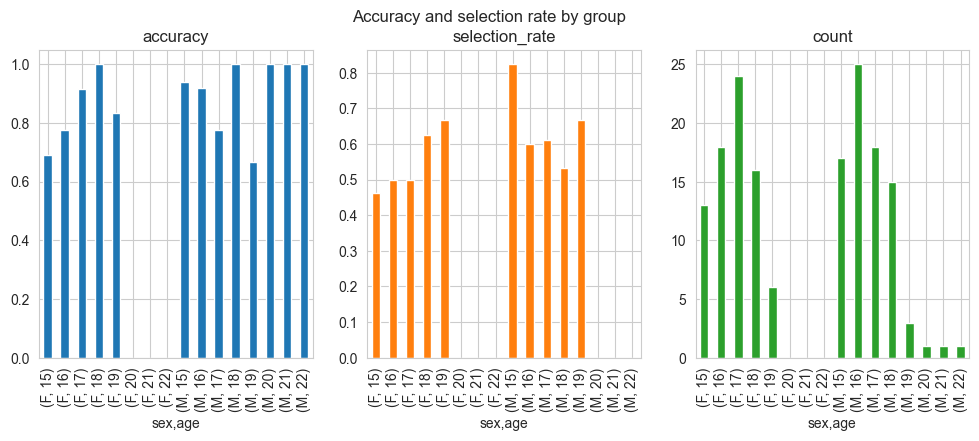

In [28]:
import matplotlib.pyplot as plt

metric_frame = MetricFrame(
    metrics={
        "accuracy": performance_metric,
        "selection_rate": fairness_metric,
        "count": count,
    },
    sensitive_features=A_test,
    y_true=Y_test,
    y_pred=grid_search.predict(X_test),
)

print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[1, 3],
    legend=False,
    figsize=[12, 4],
    title="Accuracy and selection rate by group",
)

### GridSearch from fairlearn libriry

In [29]:
sweep = GridSearch(
    DecisionTreeClassifier(),
    constraints=DemographicParity(),
    grid_size=100,
)
sweep.fit(X_train, Y_train, sensitive_features=A_train)

predictors = sweep.predictors_
print(f"predictors: {predictors}")

The grid has 11 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 100 grid points. It is recommended to use at least 2048 grid points. Please consider increasing grid_size.


predictors: [DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier(),

In [30]:
import matplotlib.pyplot as plt

errors, disparities = [], []
for p in predictors:

    def classifier(X):
        return p.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    errors.append(error.gamma(classifier)[0])

    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    disparities.append(disparity.gamma(classifier).max())

In [31]:
grid_results = pd.DataFrame(
    {"predictor": predictors,
     "error": errors,
     "disparity": disparities}
)

non_dominated_models = []
for model in grid_results.itertuples():
    if model.error < grid_results["error"][grid_results["disparity"] < model.disparity].min():
        non_dominated_models.append(model.predictor)

In [32]:
import matplotlib.pyplot as plt

predictions = {"unmitigated_model": grid_search.predict(X_test)}

metric_frames = {"unmitigated_model": metric_frame}
for i in range(len(non_dominated_models)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated_models[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": performance_metric,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=A_test,
        y_true=Y_test,
        y_pred=predictions[key],
    )

No matplotlib.Axes object was provided to draw on, so we create a new one


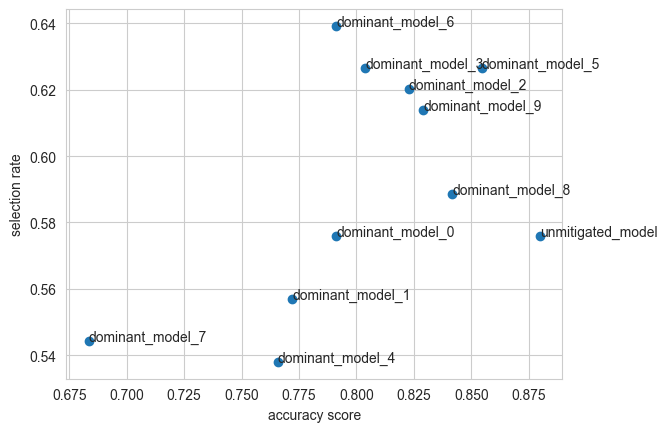

<AxesSubplot: xlabel='accuracy score', ylabel='selection rate'>

In [33]:
import matplotlib.pyplot as plt

plot_model_comparison(
    x_axis_metric=performance_metric,
    y_axis_metric=fairness_metric,
    y_true=Y_test,
    y_preds=predictions,
    sensitive_features=A_test,
    point_labels=True,
    show_plot=True,
)

In [34]:
y_pred = grid_search.predict(X_test)

In [35]:
dpr = demographic_parity_ratio(Y_test, y_pred, sensitive_features=A_test)
print(f"demographic parity ratio: {dpr}")

demographic parity ratio: 0.0


In [36]:
dpd = demographic_parity_difference(Y_test, y_pred, sensitive_features=A_test)
print(f"demographic parity difference: {dpd}")

demographic parity difference: 0.8235294117647058


In [37]:
m_eqo = equalized_odds_difference(Y_test, y_pred, sensitive_features=A_test)
print(f'Value of equal odds ratio: {round(m_eqo, 2)}')

Value of equal odds ratio: 1.0


### air360

In [38]:
!pip install scikit-learn==1.2.0

  Using cached scikit_learn-1.2.0-cp39-cp39-macosx_10_9_x86_64.whl (9.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
You should consider upgrading via the '/Users/tarasbohdan/Desktop/university/Experiments-AAAI-24/virny_venv/bin/python3.9 -m pip install --upgrade pip' command.


In [39]:
!pip install aif360['all'] virny

zsh:1: no matches found: aif360[all]


In [50]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import StandardDataset

from virny.datasets.base import BaseDataLoader

In [51]:
sensitive_attribute='sex'

In [52]:
df = pd.read_csv(Config.file_name, delimiter=";")
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [53]:
class StudentPerformanceDataset(BaseDataLoader):

  def __init__(self, dataset_path):
    df = pd.read_csv(dataset_path, delimiter=";")

    y_df = (df['G3'] >= 10) * 1

    df.drop(['G3'], axis=1, inplace=True)
    df['target'] = y_df

    target = 'target'
    categorical_columns = ['Mjob', 'Fjob', 'reason', 'guardian']
    numerical_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                          'absences', 'G1', 'G2']

    super().__init__(
        full_df=df,
        target=target,
        numerical_columns=numerical_columns,
        categorical_columns=categorical_columns
    )


  def one_hot_encode(self, df, categorical_columns):
    for column in categorical_columns:
      dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
      df = pd.concat([df, dummies], axis=1)
      df.drop(column, axis=1, inplace=True)
    return df



In [54]:
dataset = StudentPerformanceDataset(Config.file_name)

In [55]:
dir(dataset)

['X_data',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'categorical_columns',
 'columns_with_nulls',
 'features',
 'full_df',
 'numerical_columns',
 'one_hot_encode',
 'target',
 'y_data']

In [56]:
dataset.full_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,target
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,0
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,1
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,0
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,1


In [57]:
import copy
from aif360.datasets import BinaryLabelDataset


def remove_disparate_impact(init_base_flow_dataset, alpha):
    base_flow_dataset = copy.deepcopy(init_base_flow_dataset)
    sensitive_attribute = 'sex'

    X_data = base_flow_dataset.X_data

    X_data = pd.get_dummies(X_data)

    X_data[base_flow_dataset.target] = base_flow_dataset.y_data
    X_data[sensitive_attribute] = base_flow_dataset.full_df[sensitive_attribute].map(lambda x: 1 if x == 'M' else 0)

    train_binary_dataset = BinaryLabelDataset(df=X_data,
                                              label_names=[base_flow_dataset.target],
                                              protected_attribute_names=[sensitive_attribute],
                                              favorable_label=1,
                                              unfavorable_label=0)

    di = DisparateImpactRemover(repair_level=alpha, sensitive_attribute=sensitive_attribute)
    train_repaired_df, _ = di.fit_transform(train_binary_dataset).convert_to_dataframe()
    train_repaired_df.index = train_repaired_df.index.astype(dtype='int64')

    base_flow_dataset.X_data = train_repaired_df.drop([base_flow_dataset.target], axis=1)
    base_flow_dataset.y_data = train_repaired_df[base_flow_dataset.target]

    return base_flow_dataset

In [58]:
cur_base_flow_dataset = remove_disparate_impact(dataset, alpha=0.4)

In [59]:
cur_base_flow_dataset.full_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,target
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,0
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,1
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,0
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,1


In [60]:
X = cur_base_flow_dataset.X_data
y = cur_base_flow_dataset.y_data

In [61]:
X.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'sex'],
      dtype='object')

In [62]:
grouped = X_df.groupby('sex')['score_greater_10'].value_counts().unstack().fillna(0)
DI_before = (grouped.loc['F', 1] / grouped.loc['F', :].sum()) / (grouped.loc['M', 1] / grouped.loc['M', :].sum())

print("Disparate Impact (DI) Before Fairness Measures:", DI_before)

KeyError: 'Column not found: score_greater_10'

In [63]:
X['score_greater_10'] = y
grouped = X.groupby('sex')['score_greater_10'].value_counts().unstack().fillna(0)
DI_before = (grouped.loc[0, 1] / grouped.loc[0, :].sum()) / (grouped.loc[1, 1] / grouped.loc[1, :].sum())

print("Disparate Impact (DI) Before Fairness Measures:", DI_before)
X.drop(['score_greater_10'], axis=1, inplace=True)

Disparate Impact (DI) Before Fairness Measures: 0.9058493589743588


In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
count_df.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title("Distribution of 'score >= 10' by Sex")

plt.show()

/var/folders/cg/l243p36n10s5v1x_vrt2wzs80000gn/T/ipykernel_83473/2638745498.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)

In [66]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [67]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [68]:
y_pred = model.predict(X_test)

score = accuracy_score(Y_test, y_pred)
print(f"accuracy: {score}")

report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)

accuracy: 0.8544303797468354
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.68      0.78        59
         1.0       0.83      0.96      0.89        99

    accuracy                           0.85       158
   macro avg       0.87      0.82      0.83       158
weighted avg       0.86      0.85      0.85       158



In [69]:
# TODO research how it affects metrics?

In [70]:
dpr = demographic_parity_ratio(Y_test, y_pred, sensitive_features=A_test)
print(f"demographic parity ratio: {dpr}")

demographic parity ratio: 0.0


In [71]:
dpd = demographic_parity_difference(Y_test, y_pred, sensitive_features=A_test)
print(f"demographic parity difference: {dpd}")

demographic parity difference: 1.0


In [72]:
m_eqo = equalized_odds_difference(Y_test, y_pred, sensitive_features=A_test)
print(f'Value of equal odds ratio: {round(m_eqo, 2)}')

Value of equal odds ratio: 1.0
